Классификация по тональности

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.
Часть 1. Анализ текстов

    Посчитайте количество отзывов в разных городах и на разные банки
    Постройте гистограмы длин слов в символах и в словах
    Найдите 10 самых частых:

    слов
    слов без стоп-слов
    лемм
    существительных

    Постройте кривые Ципфа и Хипса
    Ответьте на следующие вопросы:

    какое слово встречается чаще, "сотрудник" или "клиент"?
    сколько раз встречается слова "мошенничество" и "доверие"?

    В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру 

    , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

Часть 2. Тематическое моделирование

    Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
    Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

Часть 3. Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

    Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
    Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных 

    -грам.
    Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

    1-ый вариант: 

    преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
    2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [ ]:
import json

import bz2
import re
from tqdm import tqdm
from scipy import sparse
from collections import Counter

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:40, 4913.01it/s]


In [ ]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


## Посчитайте количество отзывов в разных городах и на разные банки

In [ ]:
grouped = df.groupby(['city', 'bank_name'])['num_comments'].sum().reset_index()
grouped.sort_values(by='num_comments', ascending=False)

,city,bank_name,num_comments
7453,г. Москва,Сбербанк России,33488
7489,г. Москва,Тинькофф Банк,25235
7437,г. Москва,Русский Стандарт,14208
7140,г. Москва,Авангард,14022
7160,г. Москва,Альфа-Банк,12993
...,...,...,...
15438,г. Чебоксары,Кредит Европа Банк,0
2842,г. Даниловка,Азиатско-Тихоокеанский Банк,0
6311,г. Липецк,Московский Кредитный Банк,0
2843,г. Данков,Восточный Экспресс Банк,0


## Постройте гистограмы длин слов в символах и в словах

In [ ]:
df['test_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

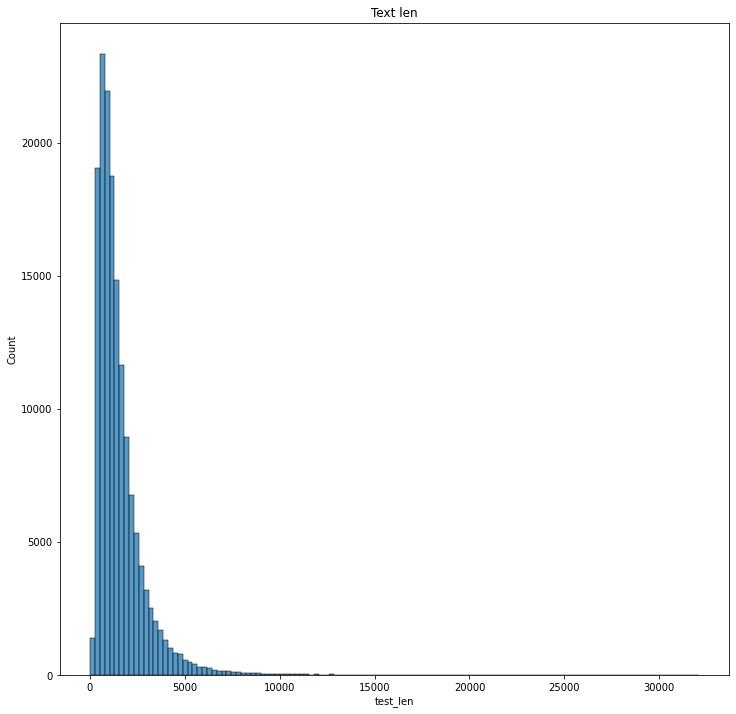

In [ ]:
plt.figure(figsize=(12,12)) 
sns.histplot(df['test_len'], bins=125)
plt.title('Text len')
plt.show();

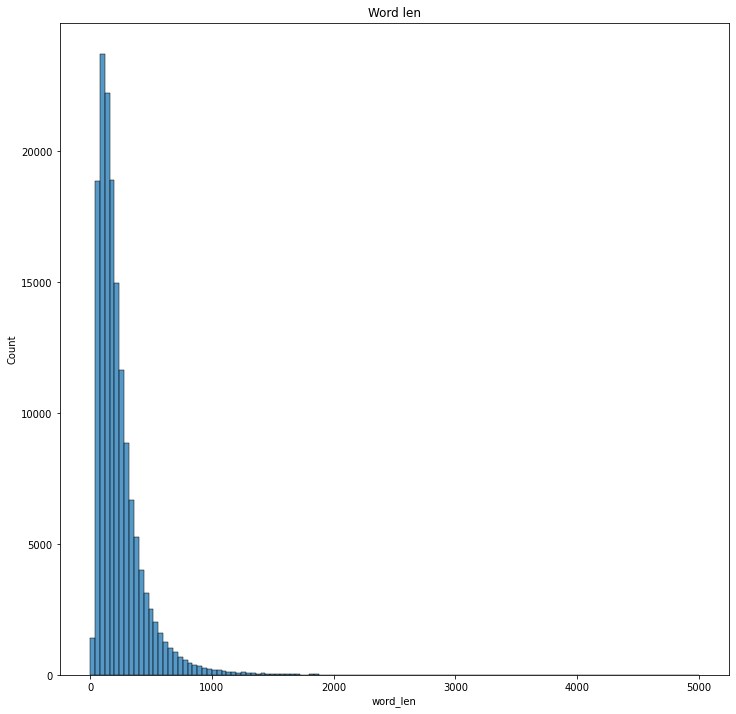

In [ ]:
plt.figure(figsize=(12,12)) 
sns.histplot(df['word_len'], bins=125)
plt.title('Word len')
plt.show();

##     Найдите 10 самых частых:

    слов
    слов без стоп-слов
    лемм
    существительных


### Приведем все к нижнему регистру и уберем личшние символы, по сути все кроме слов

In [ ]:
df['text'] = df['text'].str.replace('[^а-яА-Я -]+', '', regex=True).str.replace('\s+', ' ', regex=True).str.lower()

In [ ]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,добрый день я не являюсь клиентом банка и пору...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,доброго дня являюсь держателем зарплатной карт...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,здравствуйте дублирую свое заявление от в до м...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,добрый день я открыл расчетный счет в сбербанк...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,г взяла кредит в вашем банке заявленная мною ...,NaN


### Т.к. через датафрейм почему-то очень долго считается сумма по серии, то возьмем изначальный список словарем, уберем лишнее, соберем единый список и посчитаем количество

In [ ]:
# ТОП 10 слов
words = []
for res in tqdm(responses):
  res['text'] = re.sub('\s+', ' ', res['text'])
  words += re.sub('[^а-яА-Я -]+', '', res['text']).lower().split()

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [00:20<00:00, 7487.11it/s]


In [ ]:
Counter(words).most_common()[:10]

[('в', 1323022),
 ('и', 1054682),
 ('не', 854518),
 ('на', 704480),
 ('что', 620936),
 ('я', 575418),
 ('с', 455462),
 ('по', 365152),
 ('-', 338389),
 ('мне', 320651)]

In [ ]:
# Не хватает памяти на такие способы
# df['text'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0)

# word_count = Counter(df['text'].str.split(' ').sum()).most_common()[:10]

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
stopwords_set = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# ТОП слов без стоп слов
words_st = [msg for msg in words if msg not in stopwords_set + ['-', 'это', 'также', 'а', 'аа']]
Counter(words_st).most_common()[:10]

[('банка', 263947),
 ('банк', 196294),
 ('деньги', 130087),
 ('карту', 104967),
 ('карты', 100919),
 ('кредит', 80265),
 ('день', 76001),
 ('заявление', 69525),
 ('отделение', 66470),
 ('очень', 66169)]

In [ ]:
# Приведение слова к нормальной форме
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
words_lem = [wl.lemmatize(word) for word in words_st]
words_lem[:10]

['добрый',
 'день',
 'являюсь',
 'клиентом',
 'банка',
 'поручителем',
 'кредитному',
 'договору',
 'являюсь',
 'каким-либо']

In [ ]:
lem_count = Counter(words_lem).most_common()[:10]
lem_count

[('банка', 263947),
 ('банк', 196294),
 ('деньги', 130087),
 ('карту', 104967),
 ('карты', 100919),
 ('кредит', 80265),
 ('день', 76001),
 ('заявление', 69525),
 ('отделение', 66470),
 ('очень', 66169)]

In [ ]:
# С помощью другой библиотеки
import pymorphy2
m = pymorphy2.MorphAnalyzer(lang='ru')

In [ ]:
lemms = []
sush = []
for word in tqdm(words_st):
  lemms.append(m.parse(word)[0].normal_form)
  if m.parse(word)[0].tag.cyr_repr.split(',')[0] == 'СУЩ':
    sush.append(m.parse(word)[0].normal_form)

100%|██████████████████████████████████████████████████████████████████| 21932216/21932216 [1:41:14<00:00, 3610.59it/s]


In [ ]:
# Леммы
Counter(lemms).most_common()[:10]

[('банк', 624308),
 ('карта', 331892),
 ('деньга', 178378),
 ('день', 172215),
 ('мой', 161103),
 ('кредит', 154882),
 ('который', 148846),
 ('отделение', 143611),
 ('сотрудник', 133637),
 ('клиент', 132953)]

In [ ]:
# Существительные
Counter(sush).most_common()[:10]

[('банк', 624308),
 ('карта', 331892),
 ('деньга', 178378),
 ('день', 172215),
 ('кредит', 154882),
 ('отделение', 143611),
 ('сотрудник', 133637),
 ('клиент', 132953),
 ('счёт', 125002),
 ('сумма', 110905)]

## Кривые Ципфа и Хипса

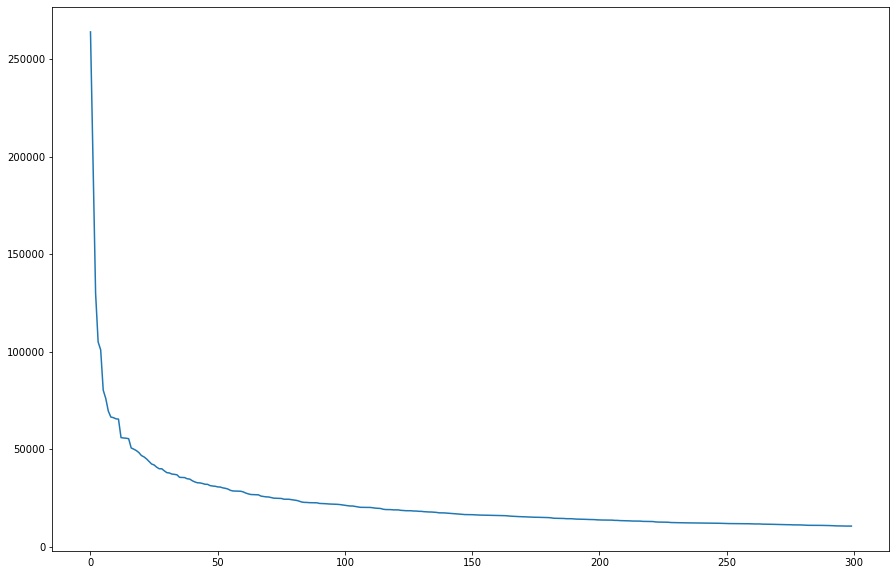

In [ ]:
# Ципфа
plt.figure(figsize=(15,10))
plt.plot(range(300), sorted(list(Counter(words_lem).values()), reverse = True)[:300])
plt.show();

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Хипс
cnt = Counter()
n_words = []
n_tokens =[]
tokens = []
for id, row in tqdm(df.iterrows(), total = len(df)):
    tokens = nltk.word_tokenize(row['text'])
    cnt.update([token for token in tokens])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|██████████████████████████████████████████████████████████████████████████| 153499/153499 [29:41<00:00, 86.18it/s]


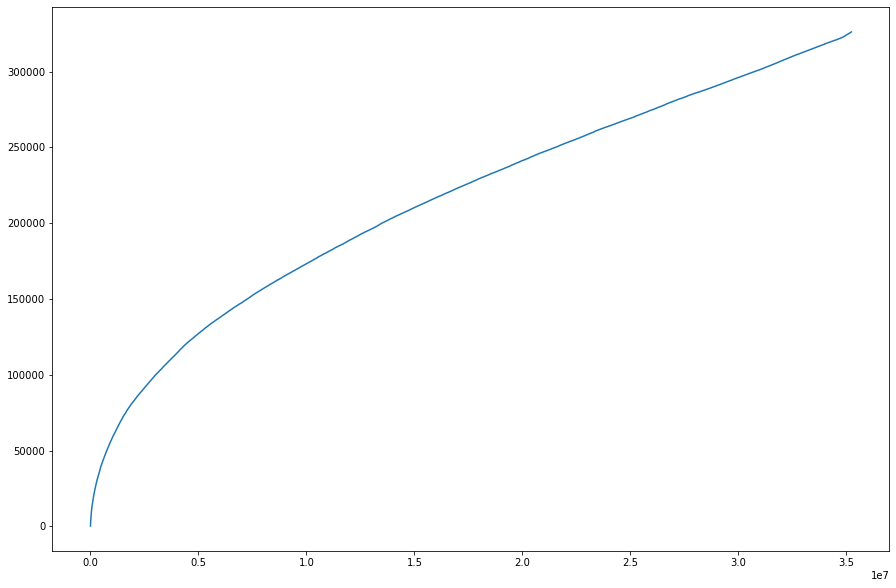

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(n_tokens, n_words)
plt.show();

##     Ответьте на следующие вопросы:

    какое слово встречается чаще, "сотрудник" или "клиент"?
    сколько раз встречается слова "мошенничество" и "доверие"?


In [ ]:
lemms_df = pd.DataFrame({'words': Counter(words_lem).keys(), 'count': Counter(words_lem).values()})
lemms_df.head()

,words,count
0,добрый,18544
1,день,76001
2,являюсь,19688
3,клиентом,25945
4,банка,263947


In [ ]:
if lemms_df.loc[lemms_df['words'] == 'сотрудник']['count'].values[0] > lemms_df.loc[lemms_df['words'] == 'клиент']['count'].values[0]:
    print('Сотрудник чаще чем клиент')
else:
    print('Клиент чаще чем сотрудник')

Сотрудник чаще чем клиент


In [ ]:
if lemms_df.loc[lemms_df['words'] == 'мошенничество']['count'].values[0] > lemms_df.loc[lemms_df['words'] == 'доверие']['count'].values[0]:
    print('Мошенничество чаще чем доверие')
else:
    print('Доверие чаще чем мошенничество')

Доверие чаще чем мошенничество


## В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
grade_1 = df.loc[df['rating_grade'] == 1]
grade_5 = df.loc[df['rating_grade'] == 5]

In [ ]:
ru_words = re.compile('[А-Яа-я]+')

In [ ]:
def words_only(text):
    return ' '.join(ru_words.findall(text))


def lemmatize(text):
    try:
        return ' '.join([m.parse(w)[0].normal_form for w in text.lower().split()])
    except:
        return ' '
    
    
def remove_stopwords(text, stop_words=stopwords_set+['-', 'это', 'также']):
    try:
        return ' '.join([token for token in text.split() if token not in stop_words])
    except:
        return ' '
    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))
    

In [ ]:
grade_1['text'] = grade_1['text'].astype('str').apply(preprocess)
grade_5['text'] = grade_5['text'].astype('str').apply(preprocess)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_23880\386445839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grade_1['text'] = grade_1['text'].astype('str').apply(preprocess)
C:\Users\Администратор\AppData\Local\Temp\ipykernel_23880\386445839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grade_5['text'] = grade_5['text'].astype('str').apply(preprocess)


In [ ]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

In [ ]:
def sort_tfidf(text):
    texts_1 = [text.split() for text in text]
    dict_ = Dictionary(texts_1)
    corpus = [dict_.doc2bow(text) for text in texts_1]
    tfIdf = TfidfModel(corpus)

    weight_tfidf =[]
    for doc in tfIdf[corpus]:
        for id, freq in doc:
            weight_tfidf.append([dict_[id], np.around(freq, decimals=5)])
            
    return sorted(weight_tfidf, key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# ТОП слов для rating_grade 1
print(sort_tfidf(grade_1['text']))

[['бпф', 0.918], ['слиток', 0.90204], ['юб', 0.89889], ['тыханский', 0.88437], ['мб', 0.87149], ['ргс', 0.86989], ['машинцев', 0.86955], ['барклайс', 0.86781], ['вексель', 0.8651], ['эпизод', 0.86133]]


In [ ]:
# ТОП слов для rating_grade 5
print(sort_tfidf(grade_5['text']))

[['канада', 0.90073], ['тумбочка', 0.89297], ['промтрансбанк', 0.88082], ['марюс', 0.84306], ['илах', 0.84182], ['семинар', 0.79991], ['пд', 0.79788], ['либо', 0.79603], ['джиргала', 0.78978], ['маштакова', 0.77617]]


## Тематическое моделирование

    Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
    
    Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их 
    прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.


In [ ]:
df['text'] = df['text'].astype('str').apply(preprocess)

In [ ]:
texts = [text.split() for text in df['text']]
dict_ = Dictionary(texts)
corpus = [dict_.doc2bow(text) for text in texts]

In [ ]:
tfIdf = TfidfModel(corpus)
corpus_tfidf = tfIdf[corpus]

In [ ]:
from gensim.models import lsimodel

In [ ]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dict_, num_topics=10)
lsi.show_topics(10)

[(0,
  '0.196*"карта" + 0.134*"кредит" + 0.116*"деньга" + 0.110*"заявление" + 0.107*"счёт" + 0.101*"вклад" + 0.101*"банкомат" + 0.101*"отделение" + 0.097*"сбербанк" + 0.096*"сумма"'),
 (1,
  '-0.438*"вклад" + 0.348*"кредит" + -0.177*"банкомат" + 0.157*"страховка" + 0.156*"платёж" + 0.150*"задолженность" + -0.145*"карта" + 0.139*"погашение" + -0.116*"очередь" + -0.111*"открыть"'),
 (2,
  '-0.458*"вклад" + 0.279*"банкомат" + 0.236*"карта" + 0.207*"сбербанк" + -0.171*"кредит" + 0.132*"операция" + -0.131*"договор" + 0.131*"заявление" + 0.123*"деньга" + 0.121*"средство"'),
 (3,
  '-0.283*"вклад" + -0.216*"сумма" + 0.201*"заявка" + 0.184*"номер" + -0.180*"руб" + -0.157*"договор" + -0.156*"платёж" + -0.154*"погашение" + -0.146*"рубль" + -0.143*"процент"'),
 (4,
  '-0.452*"карта" + 0.304*"банкомат" + -0.197*"лимит" + -0.188*"кредитный" + 0.158*"номер" + 0.128*"деньга" + 0.128*"терминал" + 0.122*"купюра" + 0.119*"звонок" + -0.114*"комиссия"'),
 (5,
  '-0.308*"банкомат" + 0.286*"вклад" + -0.252*

In [ ]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dict_, num_topics=15)
lsi.show_topics(15)

[(0,
  '0.196*"карта" + 0.134*"кредит" + 0.116*"деньга" + 0.109*"заявление" + 0.107*"счёт" + 0.102*"банкомат" + 0.101*"отделение" + 0.101*"вклад" + 0.097*"сбербанк" + 0.096*"сумма"'),
 (1,
  '-0.394*"вклад" + 0.358*"кредит" + -0.208*"банкомат" + -0.166*"карта" + 0.165*"страховка" + 0.149*"платёж" + 0.148*"задолженность" + 0.141*"погашение" + -0.118*"деньга" + 0.115*"звонок"'),
 (2,
  '-0.494*"вклад" + 0.278*"банкомат" + 0.224*"карта" + 0.186*"сбербанк" + -0.137*"кредит" + 0.135*"заявление" + 0.124*"операция" + -0.122*"договор" + 0.120*"средство" + 0.118*"деньга"'),
 (3,
  '-0.282*"вклад" + -0.219*"сумма" + -0.189*"руб" + 0.187*"номер" + 0.172*"заявка" + -0.157*"платёж" + -0.154*"договор" + -0.149*"рубль" + -0.149*"погашение" + -0.148*"процент"'),
 (4,
  '-0.324*"карта" + 0.284*"вклад" + 0.273*"номер" + -0.199*"страховка" + 0.192*"звонок" + -0.166*"заявка" + -0.162*"лимит" + -0.151*"кредитный" + 0.139*"ваш" + 0.139*"телефон"'),
 (5,
  '0.457*"банкомат" + -0.301*"карта" + -0.166*"вклад" 

In [ ]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dict_, num_topics=20)
lsi.show_topics(20)

[(0,
  '0.196*"карта" + 0.134*"кредит" + 0.116*"деньга" + 0.109*"заявление" + 0.107*"счёт" + 0.102*"банкомат" + 0.101*"вклад" + 0.101*"отделение" + 0.097*"сбербанк" + 0.096*"сумма"'),
 (1,
  '-0.380*"вклад" + 0.361*"кредит" + -0.214*"банкомат" + -0.172*"карта" + 0.166*"страховка" + 0.147*"задолженность" + 0.146*"платёж" + 0.141*"погашение" + -0.121*"деньга" + 0.117*"звонок"'),
 (2,
  '-0.503*"вклад" + 0.275*"банкомат" + 0.217*"карта" + 0.185*"сбербанк" + 0.134*"заявление" + -0.128*"кредит" + 0.120*"операция" + -0.118*"договор" + 0.117*"средство" + 0.116*"деньга"'),
 (3,
  '-0.273*"вклад" + -0.220*"сумма" + 0.190*"номер" + -0.186*"руб" + 0.175*"заявка" + -0.159*"погашение" + -0.157*"платёж" + -0.155*"договор" + -0.146*"рубль" + 0.146*"звонок"'),
 (4,
  '0.319*"вклад" + 0.276*"номер" + -0.248*"карта" + -0.214*"страховка" + 0.193*"звонок" + -0.190*"заявка" + -0.149*"кредит" + 0.141*"телефон" + 0.141*"ваш" + -0.125*"лимит"'),
 (5,
  '0.471*"банкомат" + -0.377*"карта" + 0.158*"купюра" + -0.

## Темы

1. карта, кредит, деньга, заявление, счёт, отделение, сбербанк, сумма - видимо, что-то связанное с отделением банка для взятия или открытия счета кредитной карты
2. страховка, сбербанк, заявка, страхование, документ, карта - что-то связано со страховкой средств на карте
3. курс, справка, альфа, терминал, счёт, смс, досрочный, погашение, кредитный - что-то с досрочным погашением кредита в альфа банке
4. курс, персональный, альфа, платёж, обработка, доллар, евро - что-то связанное с курсом валют в альфа банке
5. кошелёк, киви, сбербанк, вклад, идентификация, заявка, поддержка, терминал, заблокировать - видимо 

In [ ]:
result_df = df.loc[(df['rating_grade'] == 1) | (df['rating_grade'] ==5)]

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
result_df = result_df.iloc[:,-2:]

In [ ]:
vectors = TfidfVectorizer().fit_transform(result_df['text'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vectors, result_df['rating_grade'], test_size=0.2, random_state=42)

### RFC

In [ ]:
model =  RandomForestClassifier()

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
f1_score(y_test, model.predict(X_test))

0.9354631323871222

### LR

In [ ]:
model1 = LogisticRegression()

In [ ]:
model1.fit(X_train, y_train)

LogisticRegression()

In [ ]:
f1_score(y_test, model1.predict(X_test))

0.9768795136904453

### 2-2 n_gramms RFC

In [ ]:
vectors1 = TfidfVectorizer(ngram_range=(2,2)).fit_transform(result_df['text'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vectors1, result_df['rating_grade'], test_size=0.2, random_state=42)

In [ ]:
model2 =  RandomForestClassifier()

In [ ]:
model2.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
f1_score(y_test, model2.predict(X_test))

0.9290132547864508

### 2-2 n_gramms LR

In [ ]:
model3 =  LogisticRegression()

In [ ]:
model3.fit(X_train, y_train)

LogisticRegression()

In [ ]:
f1_score(y_test, model3.predict(X_test))

0.9410887397464578

### LatentDirichletAllocation

In [ ]:
model4 = LatentDirichletAllocation()

In [ ]:
model3.fit(X_train, y_train)

LogisticRegression()

In [ ]:
f1_score(y_test, model3.predict(X_test))

0.9410887397464578

In [ ]:
accuracy_score(y_test, model3.predict(X_test))

0.9045893719806763

## Вывод:
Качество не улучшается с увеличение n gramm